<a href="https://colab.research.google.com/github/ereinha/PMAE/blob/main/UCI_Higgs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ereinha/PMAE

Cloning into 'PMAE'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 235 (delta 45), reused 57 (delta 31), pack-reused 150
Receiving objects: 100% (235/235), 75.28 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [ ]:
%cd PMAE

/content/PMAE


In [ ]:
!pwd

/content/PMAE


In [ ]:
import train
import utils
import test_and_plot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
from models import classifier, pmae
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [ ]:
# Download the files from UCI ML repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gzip -d HIGGS.csv.gz

--2023-07-25 06:04:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [      <=>           ]   2.62G  58.7MB/s    in 48s     

2023-07-25 06:05:02 (56.4 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [ ]:
# Read in the csv
data = pd.read_csv('./HIGGS.csv', header=None)

In [ ]:
# Split the data and labels
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [ ]:
# Get the inputs and outputs
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [ ]:
# Grab only the first 500k items
X = X[:500000]
y = y[:500000]

In [ ]:
print(X.shape)

(500000, 28)


In [ ]:
# Remove high level features and add 0 padding to line up related quantities
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]], axis=-1)
X = np.insert(X, obj=np.s_[3:4], values=0, axis=-1)
X = np.insert(X, obj=np.s_[5:6], values=0, axis=-1)
X = np.insert(X, obj=np.s_[7:8], values=0, axis=-1)

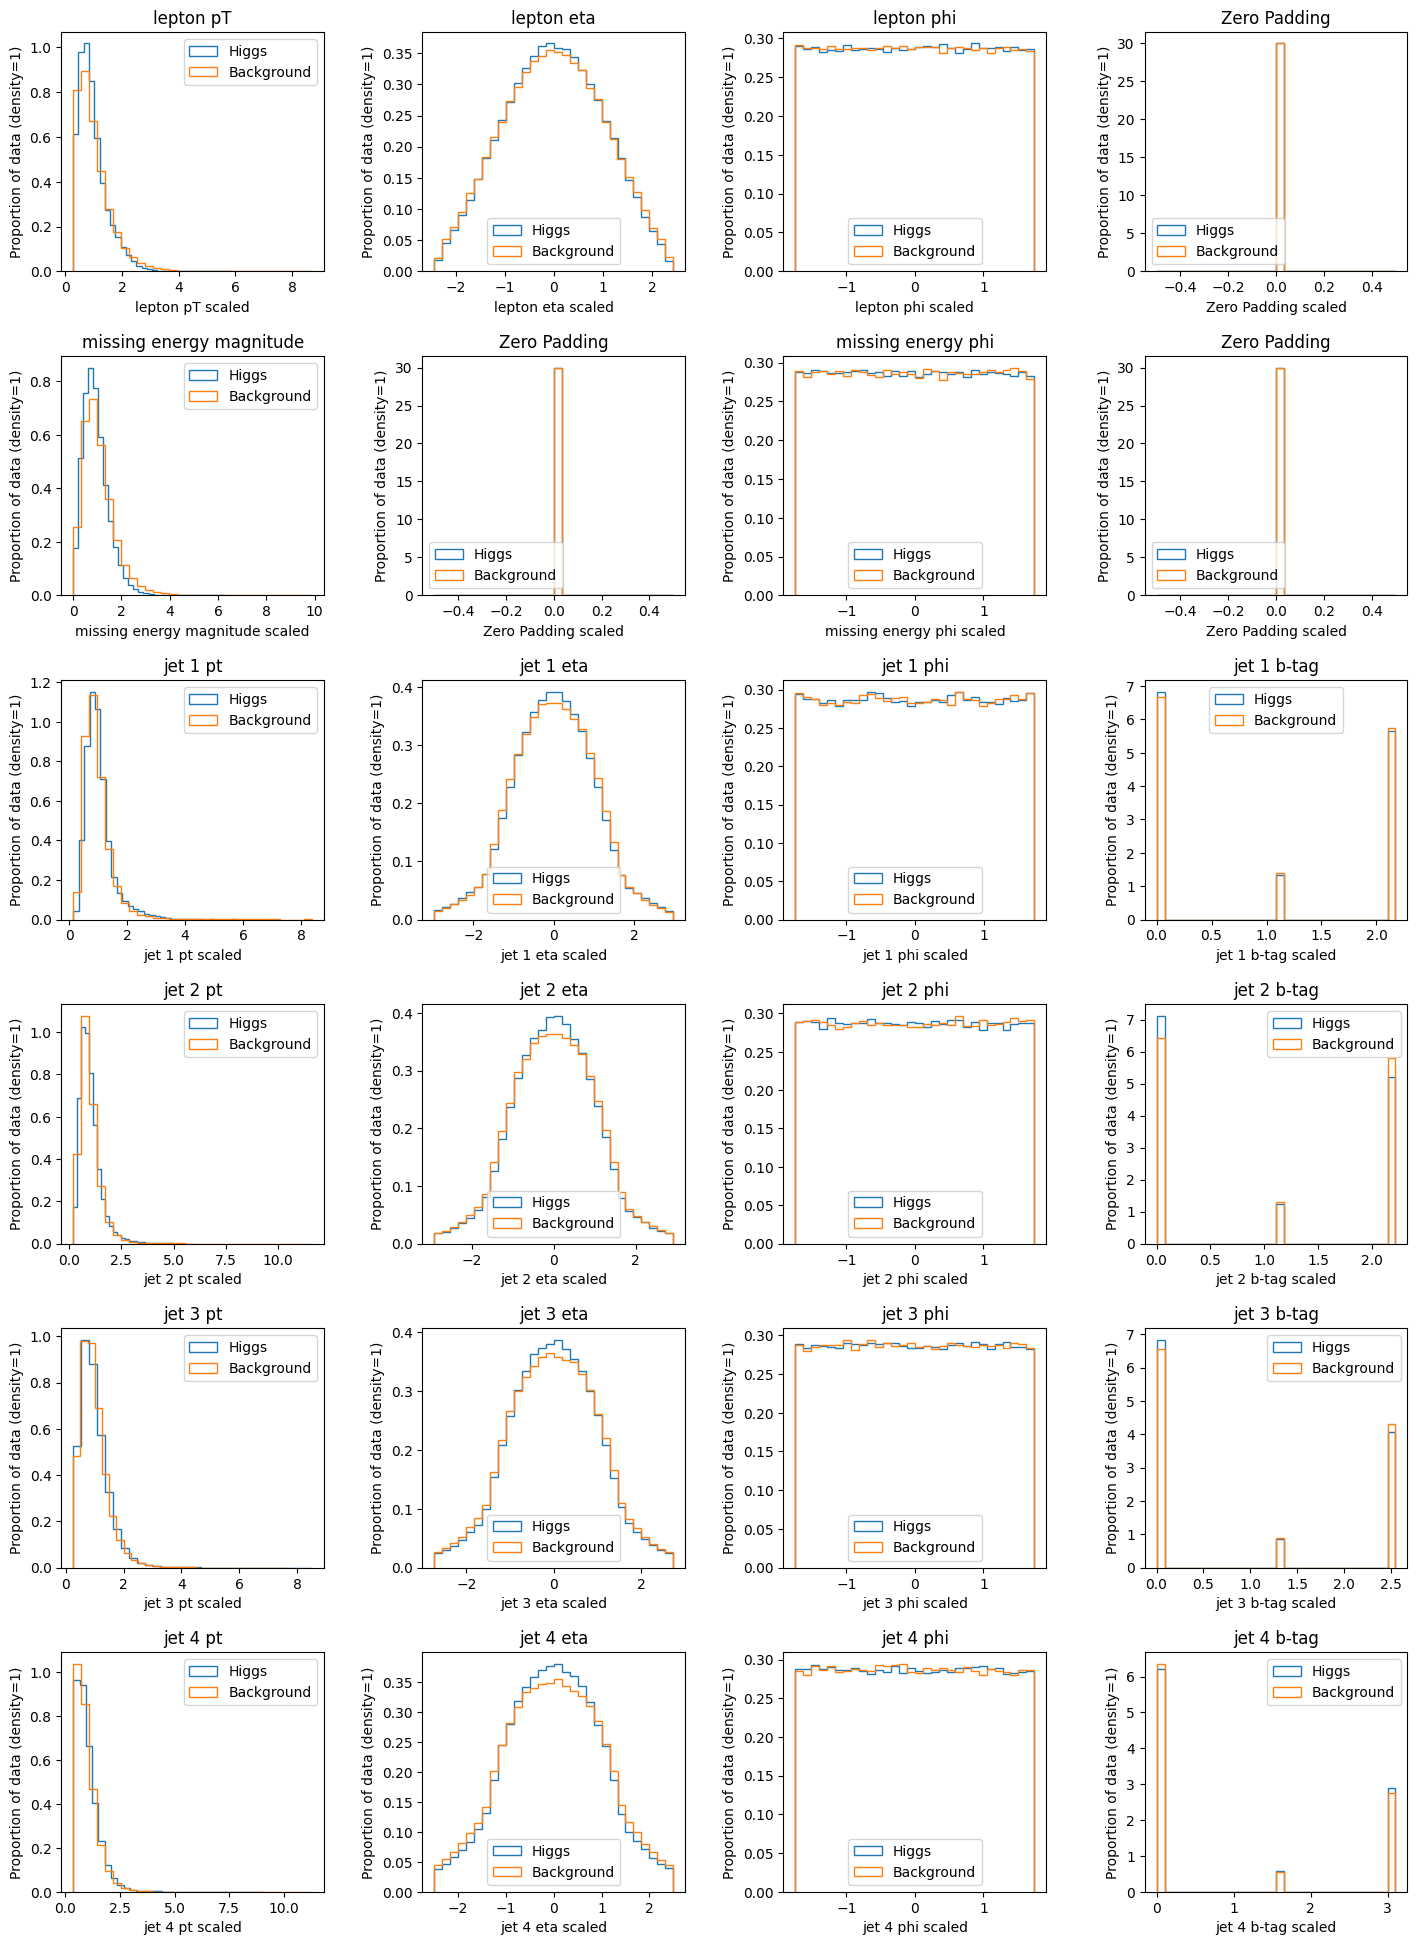

In [ ]:
# Visualizing the data
names = ["lepton pT", "lepton eta", "lepton phi", "Zero Padding",
         "missing energy magnitude", "Zero Padding", "missing energy phi", "Zero Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

fig, axes = plt.subplots(6,4, figsize=(15,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_nohiggs = X[y==0]
y_higgs = y[y==1]
y_nohiggs = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_nohiggs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*4+j])
        axes[i,j].set_xlabel(names[i*4+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [ ]:
print(len(X_higgs))
print(len(X_nohiggs))

264703
235297


In [ ]:
# Create data labels for Higgs and Non-Higgs (ttbar) data (for the UCI set we can also use the y values)
labels_hh = np.ones(len(X_higgs))
labels_tt = np.zeros(len(X_nohiggs))

In [ ]:
# Split the Higgs data into train and test sets .8, .1, .1
X_hh_train, X_val1, labels_hh_train, labels_val1 = train_test_split(X_higgs, labels_hh, test_size=0.2, random_state=42)
X_hh_val, X_hh_test, labels_hh_val, labels_hh_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [ ]:
# Normalize data relative to the Higgs train data
x_scaler = StandardScaler()
X_hh_train = x_scaler.fit_transform(X_hh_train)
X_hh_val = x_scaler.transform(X_hh_val)
X_hh_test = x_scaler.transform(X_hh_test)
X_nohiggs = x_scaler.transform(X_nohiggs)

In [ ]:
# Split the ttbar data into train and test sets .8, .1, .1
X_tt_train, X_val1, labels_tt_train, labels_val1 = train_test_split(X_nohiggs, labels_tt, test_size=0.2, random_state=42)
X_tt_val, X_tt_test, labels_tt_val, labels_tt_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [ ]:
print(np.shape(X_hh_train), np.shape(X_tt_train))

(211762, 24) (188237, 24)


In [ ]:
# Reshape the data to have shape [batch_size,particles,features]
X_hh_train = X_hh_train.reshape(X_hh_train.shape[0],6,4)
X_hh_val = X_hh_val.reshape(X_hh_val.shape[0],6,4)
X_hh_test = X_hh_test.reshape(X_hh_test.shape[0],6,4)
X_tt_train = X_tt_train.reshape(X_tt_train.shape[0],6,4)
X_tt_val = X_tt_val.reshape(X_tt_val.shape[0],6,4)
X_tt_test = X_tt_test.reshape(X_tt_test.shape[0],6,4)

# Compute some quantities to be used for calculation
phi_limit = np.max((abs(np.max(X_hh_train[:,0,2])), abs(np.min(X_hh_train[:,0,2])))) # Only need one value assuming phi distrubtions are all uniform
lower_pt_limit = [np.min(X_hh_train[:,0,0]), np.min(X_hh_train[:,1,0]), np.min(X_hh_train[:,2,0]), np.min(X_hh_train[:,3,0]), np.min(X_hh_train[:,4,0]), np.min(X_hh_train[:,5,0])]

In [ ]:
# Create a mixed sample of Higgs and ttbar data
X_train = np.append(X_hh_train, X_tt_train, axis=0)
X_val = np.append(X_hh_val, X_tt_val, axis=0)
X_test = np.append(X_hh_test, X_tt_test, axis=0)
labels_train = np.append(labels_hh_train, labels_tt_train, axis=0)
labels_val = np.append(labels_hh_val, labels_tt_val, axis=0)
labels_test = np.append(labels_hh_test, labels_tt_test, axis=0)

In [ ]:
# Load a config file from a json
with open('./configs/uci_higgs_config_demo.json', 'r') as f:
    config = json.load(f)

In [ ]:
model_name = (
    f'Model_DM{config["d_model"]}_H{config["num_heads"]}_L{config["num_layers"]}'
    f'_F{config["d_ff"]}_Dr{config["dropout"]}_B{config["batch_size"]}_T{config["test_batch_size"]}'
    f'_RE{config["resume_epoch"]}_NE{config["num_epochs"]}_ES{config["epochs_to_saturate"]}'
    f'_IM{config["init_momentum"]}_MM{config["max_momentum"]}_TILR{config["tae_init_lr"]}'
    f'_CILR{config["class_init_lr"]}_MSL{config["max_seq_len"]}_Mk{config["mask"]}'
    f'_A{config["alpha"]}_B{config["beta"]}_G{config["gamma"]}_D{config["delta"]}_OV{config["output_vars"]}'
    f'_WD{config["weight_decay"]}_MLR{config["min_lr"]}_LD{config["lr_decay"]}'
    f'_CIF{config["class_input_features"]}_CFD{config["class_ff_dim"]}'
)

In [ ]:
# Set device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'], config['max_seq_len'], config['output_vars'], config['dropout'], device)
# Build classifier
bin_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [ ]:
# Send the models to gpu if possible
tae.to(device)
bin_class.to(device)

BinaryClassifier(
  (linear1): Linear(in_features=48, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=1, bias=True)
  (custom_act): CustomActivationFunction()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.03, inplace=False)
)

In [ ]:
# Assign the criterion
criterion = utils.custom_loss(phi_limit, lower_pt_limit, config['alpha'], config['beta'], config['gamma'], config['delta'], config['output_vars'])
criterion_2 = nn.BCELoss()

In [ ]:
# Instantiate the dataset and DataLoader
train_data = utils.DataLabelDataset(X_train, labels_train)
train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
hh_train_data = train_data = utils.DataLabelDataset(X_hh_train, labels_hh_train)
hh_train_loader = DataLoader(hh_train_data, batch_size=config['batch_size'], shuffle=True)
val_data = utils.DataLabelDataset(X_val, labels_val)
val_loader = DataLoader(val_data, batch_size=config['test_batch_size'], shuffle=True)
hh_val_data = train_data = utils.DataLabelDataset(X_hh_val, labels_hh_val)
hh_val_loader = DataLoader(hh_val_data, batch_size=config['test_batch_size'], shuffle=True)
test_data = utils.DataLabelDataset(X_test, labels_test)
test_loader = DataLoader(test_data, batch_size=config['test_batch_size'], shuffle=False)

In [ ]:
# Build the optimizers
optimizer = utils.SGDWithSaturatingMomentumAndDecay(tae.parameters(), lr=config['tae_init_lr'], momentum=config['init_momentum'], max_momentum=config['max_momentum'],
                                                    epochs_to_saturate=config['epochs_to_saturate'], batches_per_epoch=len(train_loader), weight_decay=0,
                                                    lr_decay=config['lr_decay'], min_lr=config['min_lr'], resume_epoch=config['resume_epoch'])
optimizer_2 = utils.SGDWithSaturatingMomentumAndDecay(bin_class.parameters(), lr=config['class_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['resume_epoch'])

In [ ]:
# Train the model
val_loss_min = train.train(hh_train_loader, hh_val_loader, [tae], device, optimizer, criterion, 'autoencoder', config['output_vars'], mask=config['mask'],
                           num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Epoch [1/250], Val Loss: -0.0840
Epoch [2/250], Val Loss: -0.1001
Epoch [3/250], Val Loss: -0.1123
Epoch [4/250], Val Loss: -0.1088
Epoch [5/250], Val Loss: -0.1250
Epoch [6/250], Val Loss: -0.1278
Epoch [7/250], Val Loss: -0.1331
Epoch [8/250], Val Loss: -0.1323
Epoch [9/250], Val Loss: -0.1354
Epoch [10/250], Val Loss: -0.1356
Epoch [11/250], Val Loss: -0.1357
Epoch [12/250], Val Loss: -0.1388
Epoch [13/250], Val Loss: -0.1385
Epoch [14/250], Val Loss: -0.1390
Epoch [15/250], Val Loss: -0.1422
Epoch [16/250], Val Loss: -0.1415
Epoch [17/250], Val Loss: -0.1433
Epoch [18/250], Val Loss: -0.1404
Epoch [19/250], Val Loss: -0.1433
Epoch [20/250], Val Loss: -0.1427
Epoch [21/250], Val Loss: -0.1450
Epoch [22/250], Val Loss: -0.1403
Epoch [23/250], Val Loss: -0.1450
Epoch [24/250], Val Loss: -0.1436
Epoch [25/250], Val Loss: -0.1434
Epoch [26/250], Val Loss: -0.1456
Epoch [27/250], Val Loss: -0.1468
Epoch [28/250], Val Loss: -0.1454
Epoch [29/250], Val Loss: -0.1426
Epoch [30/250], Val Los

In [ ]:
val_loss_min = train.train(train_loader, val_loader, [tae, bin_class], device, optimizer_2, criterion_2, 'classifier partial', config['output_vars'],
                           mask=config['mask'], num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/250], Batch [500/782], Loss: 0.6613
Epoch [1/250], Val Loss: 0.6375
Epoch [2/250], Batch [500/782], Loss: 0.6333
Epoch [2/250], Val Loss: 0.6292
Epoch [3/250], Batch [500/782], Loss: 0.6247
Epoch [3/250], Val Loss: 0.6214
Epoch [4/250], Batch [500/782], Loss: 0.6173
Epoch [4/250], Val Loss: 0.6161
Epoch [5/250], Batch [500/782], Loss: 0.6123
Epoch [5/250], Val Loss: 0.6125
Epoch [6/250], Batch [500/782], Loss: 0.6096
Epoch [6/250], Val Loss: 0.6104
Epoch [7/250], Batch [500/782], Loss: 0.6054
Epoch [7/250], Val Loss: 0.6090
Epoch [8/250], Batch [500/782], Loss: 0.6037
Epoch [8/250], Val Loss: 0.6070
Epoch [9/250], Batch [500/782], Loss: 0.6017
Epoch [9/250], Val Loss: 0.6048
Epoch [10/250], Batch [500/782], Loss: 0.5998
Epoch [10/250], Val Loss: 0.6084
Epoch [11/250], Batch [500/782], Loss: 0.5984
Epoch [11/250], Val Loss: 0.6013
Epoch [12/250], Batch [500/782], Loss: 0.5960
Epoch [12/250], Val Loss: 0.6014
Epoch [13/250], Batch [500/782], Loss: 0.5921
Epoch [13/250], Val Loss

In [ ]:
val_loss_min = train.train(train_loader, val_loader, [tae, bin_class], device, optimizer_2, criterion_2, 'classifier full', config['output_vars'],
                           mask=config['mask'], num_epochs=config['num_epochs']-config['resume_epoch'], save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/250], Batch [500/782], Loss: 0.5046
Epoch [1/250], Val Loss: 0.5954
Epoch [2/250], Batch [500/782], Loss: 0.4938
Epoch [2/250], Val Loss: 0.6002
Epoch [3/250], Batch [500/782], Loss: 0.4870
Epoch [3/250], Val Loss: 0.5983
Epoch [4/250], Batch [500/782], Loss: 0.4788
Epoch [4/250], Val Loss: 0.5938
Epoch [5/250], Batch [500/782], Loss: 0.4691
Epoch [5/250], Val Loss: 0.5937
Epoch [6/250], Batch [500/782], Loss: 0.4621
Epoch [6/250], Val Loss: 0.5934
Epoch [7/250], Batch [500/782], Loss: 0.4561
Epoch [7/250], Val Loss: 0.5918
Epoch [8/250], Batch [500/782], Loss: 0.4503
Epoch [8/250], Val Loss: 0.5952
Epoch [9/250], Batch [500/782], Loss: 0.4463
Epoch [9/250], Val Loss: 0.5957
Epoch [10/250], Batch [500/782], Loss: 0.4437
Epoch [10/250], Val Loss: 0.6095
Epoch [11/250], Batch [500/782], Loss: 0.4388
Epoch [11/250], Val Loss: 0.5943
Epoch [12/250], Batch [500/782], Loss: 0.4366
Epoch [12/250], Val Loss: 0.5974
Epoch [13/250], Batch [500/782], Loss: 0.4354
Epoch [13/250], Val Loss

In [ ]:
# Parse a json config interpretation from a model name string
config = utils.parse_model_name(model_name)

In [ ]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
# Build classifier
bin_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [ ]:
# Send the models to gpu if possible
tae.to(device)
bin_class.to(device)

BinaryClassifier(
  (linear1): Linear(in_features=48, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=1, bias=True)
  (custom_act): CustomActivationFunction()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.03, inplace=False)
)

In [ ]:
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))

<All keys matched successfully>

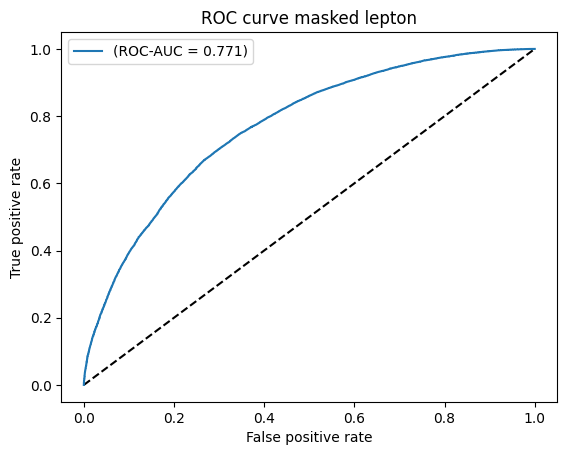

Classification Accuracy (masked  lepton ):  0.7023459530809384


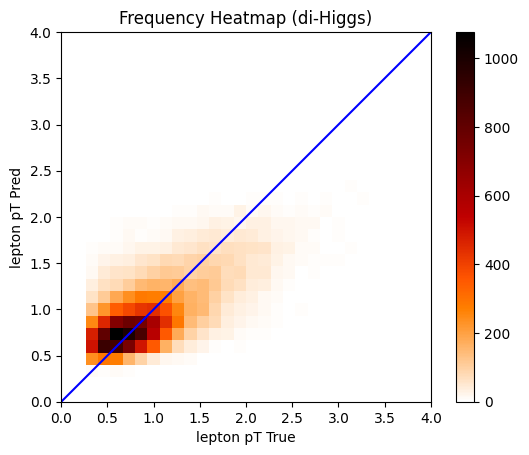

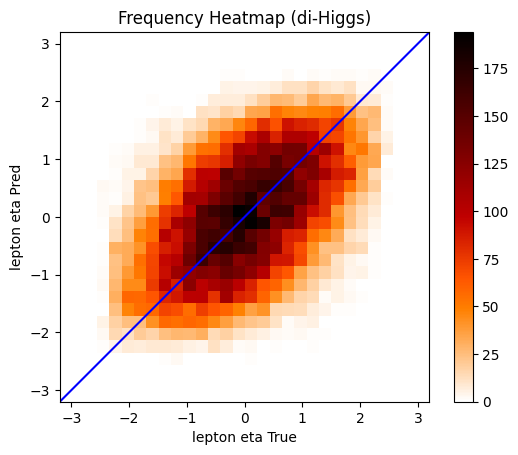

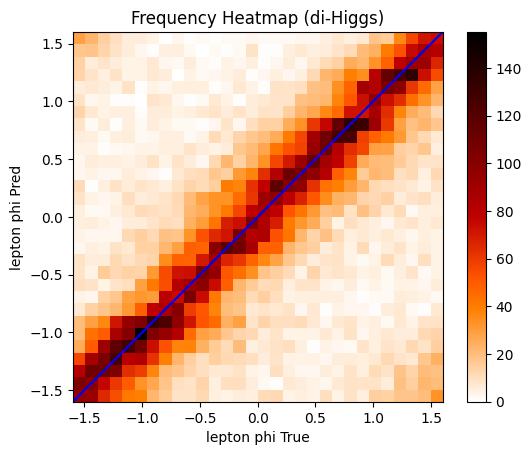

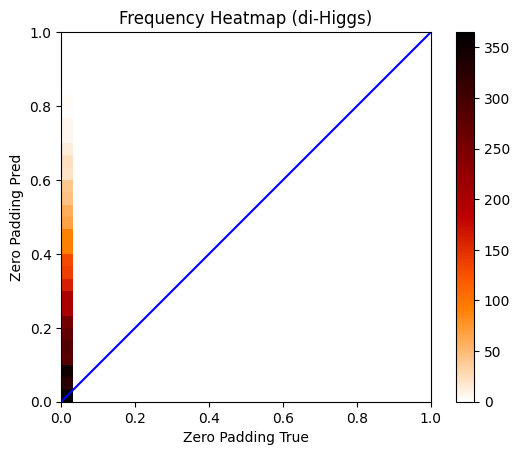

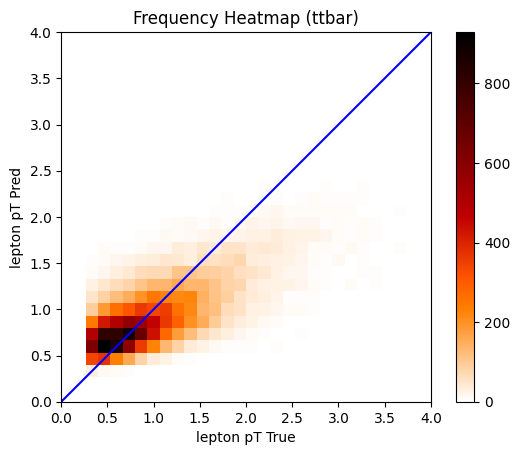

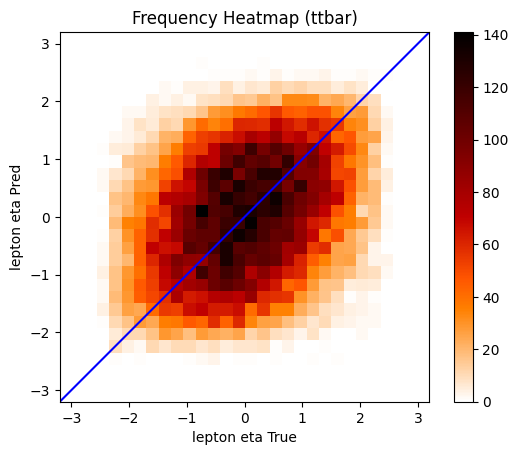

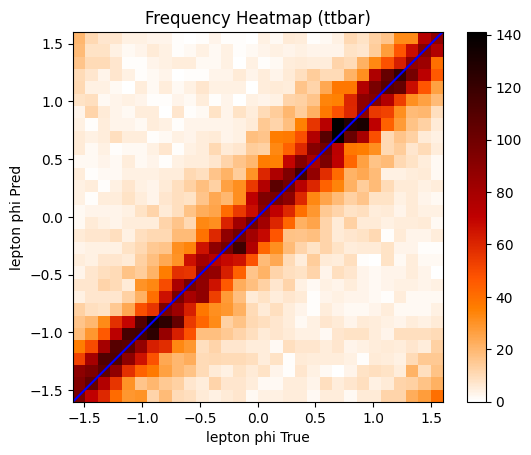

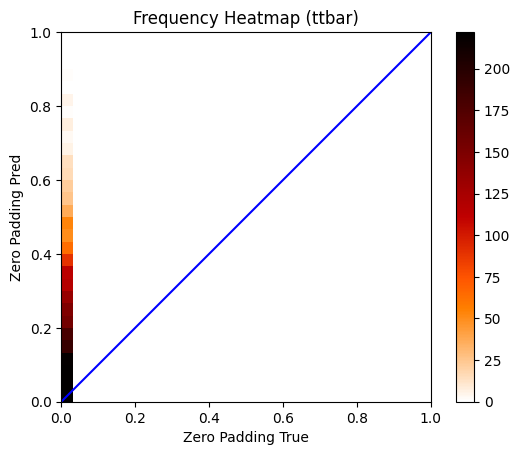

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


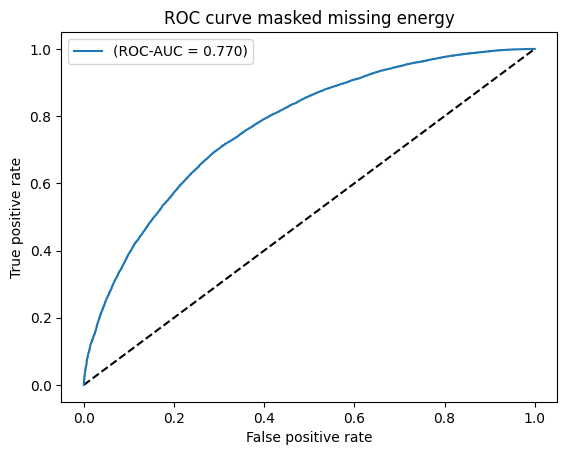

Classification Accuracy (masked  missing energy ):  0.7022659546809064


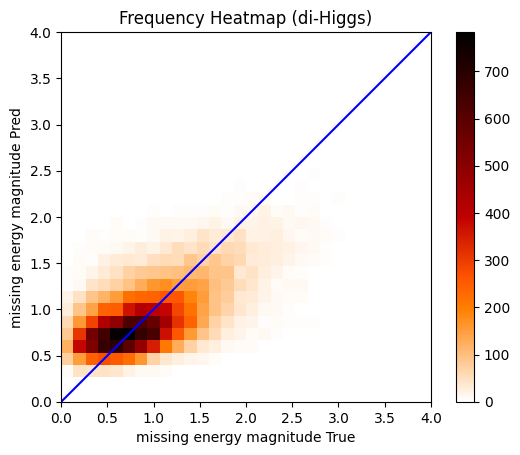

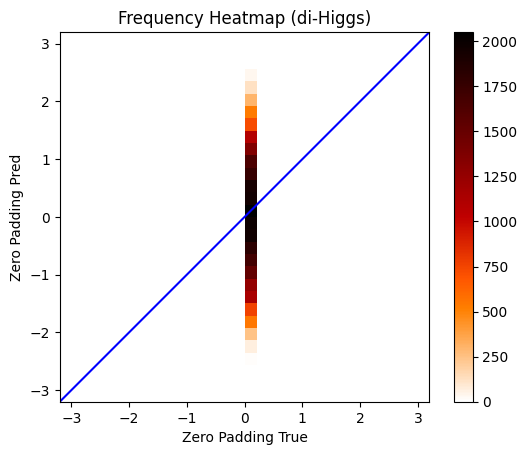

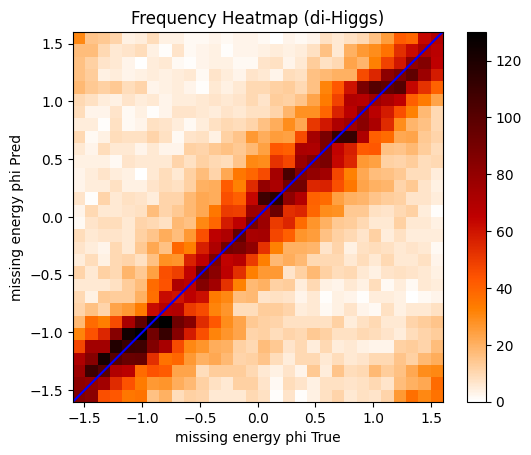

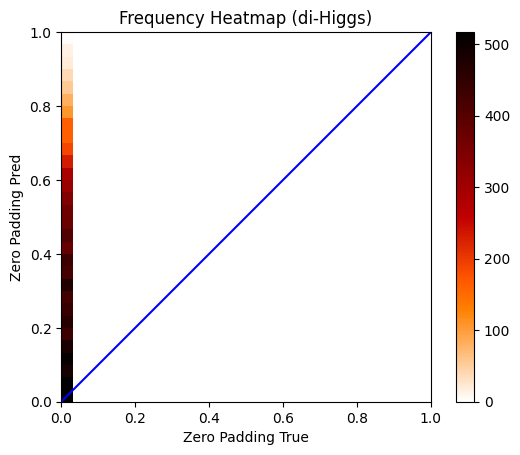

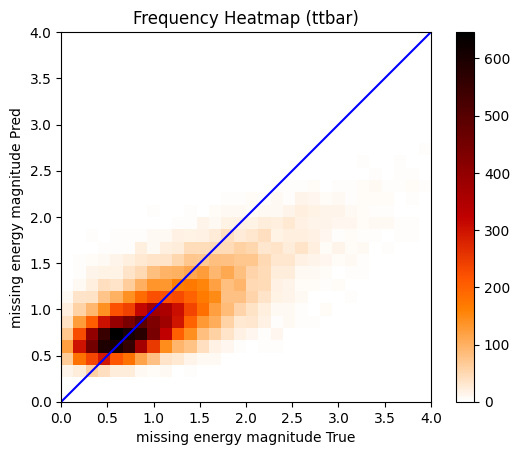

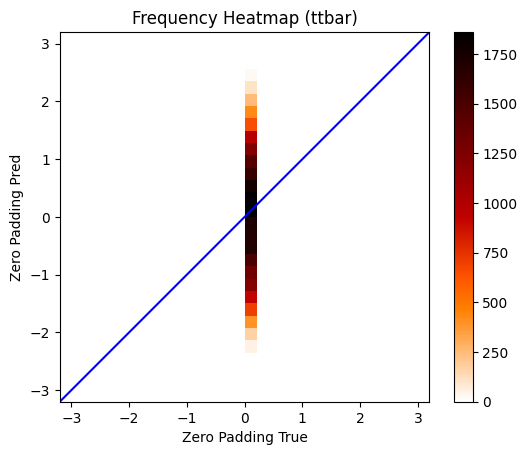

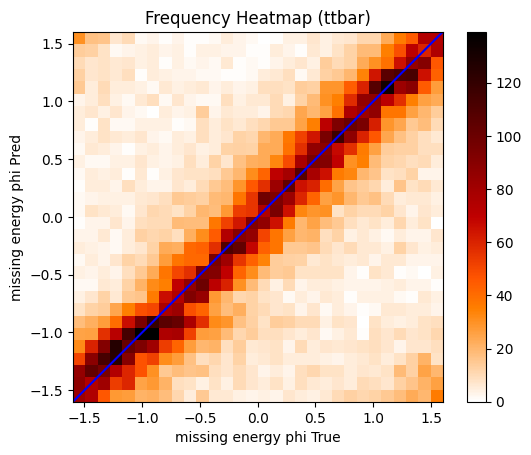

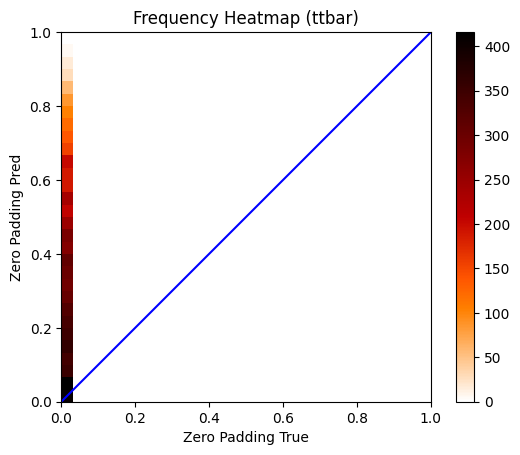

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


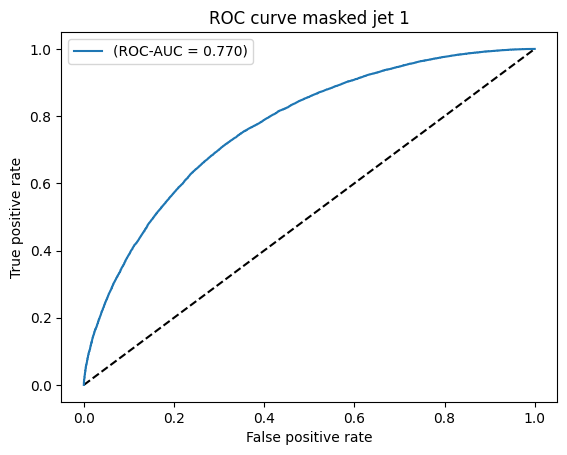

Classification Accuracy (masked  jet 1 ):  0.7022259554808904


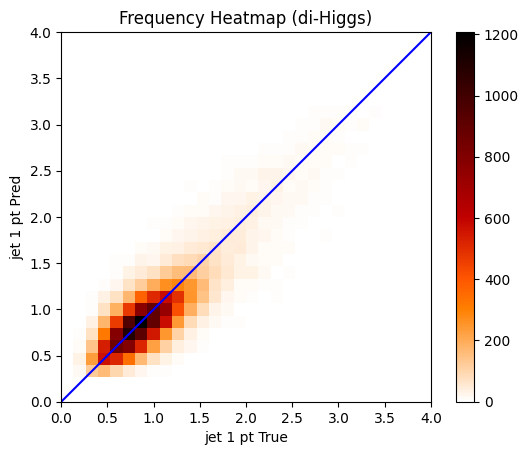

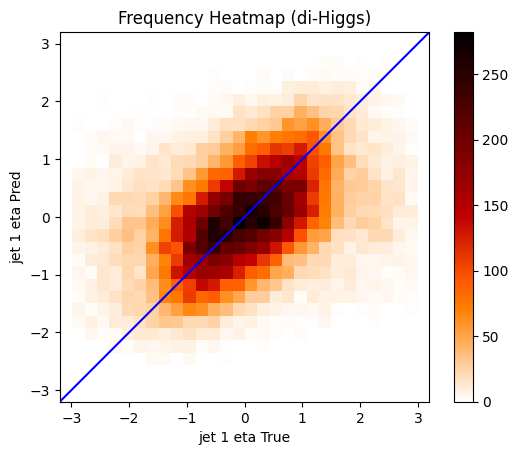

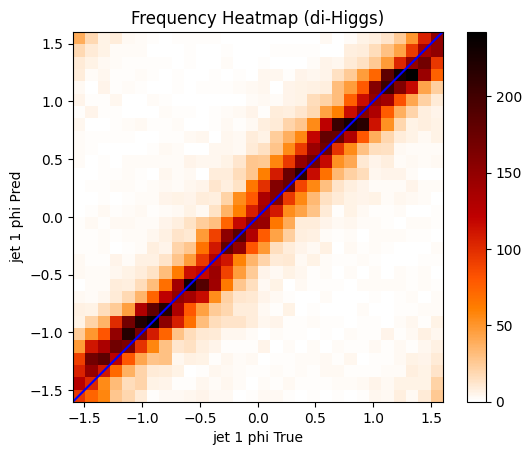

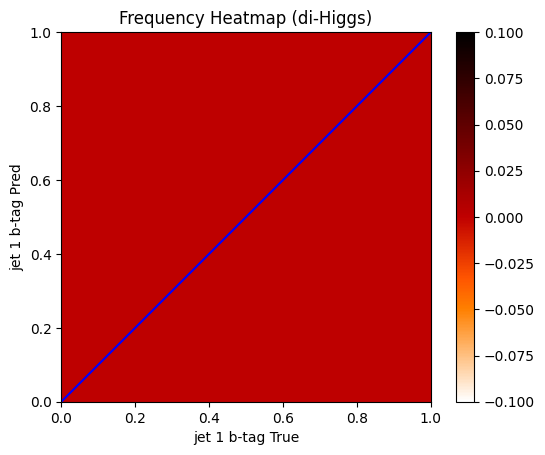

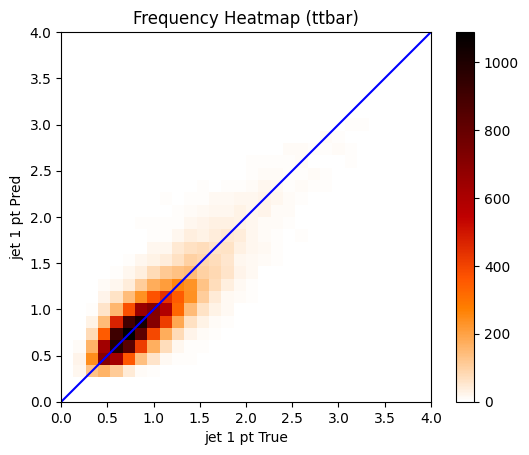

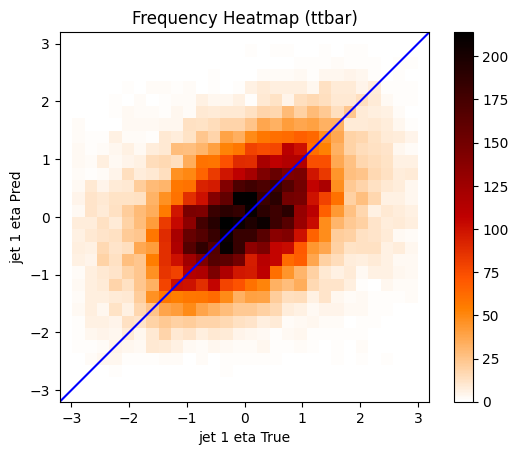

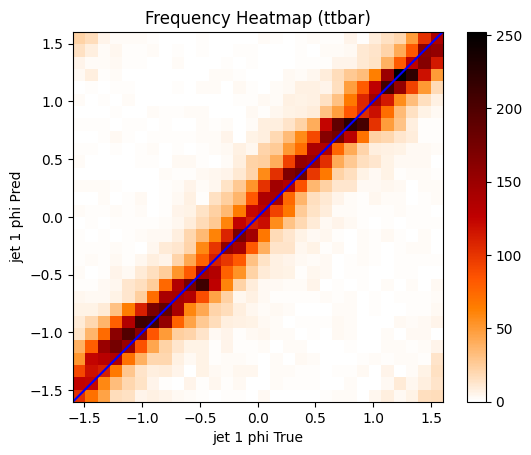

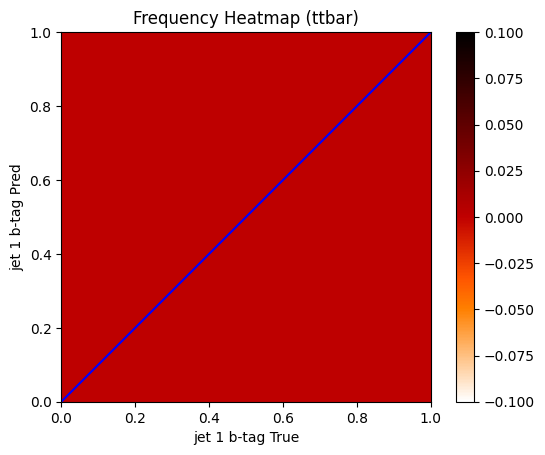

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


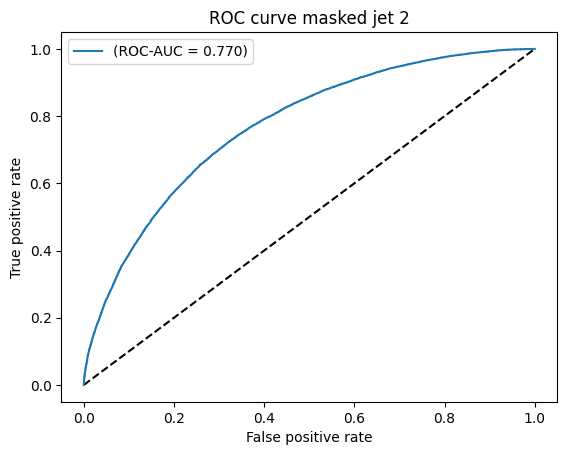

Classification Accuracy (masked  jet 2 ):  0.7026259474810503


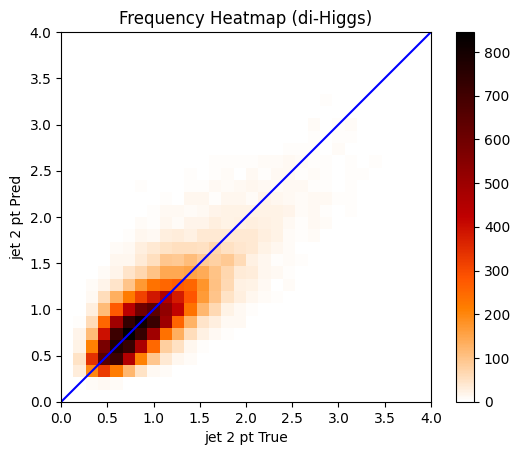

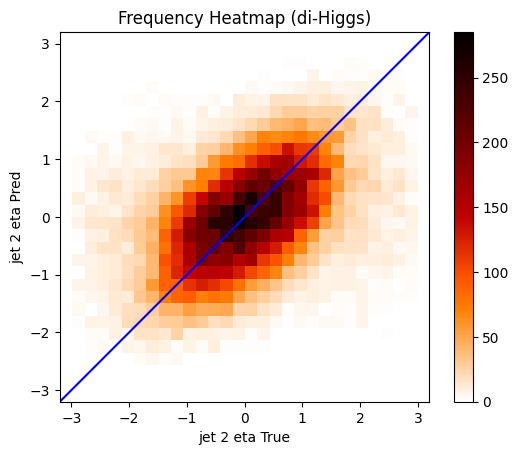

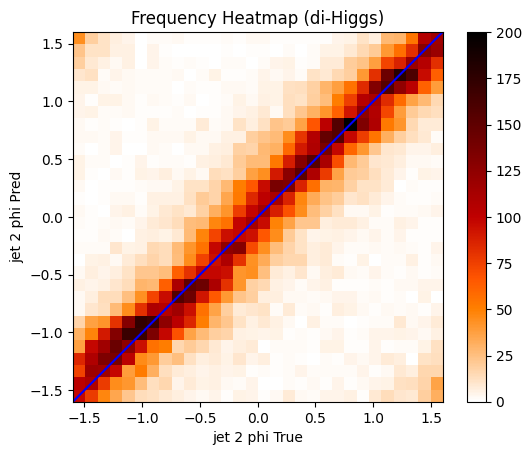

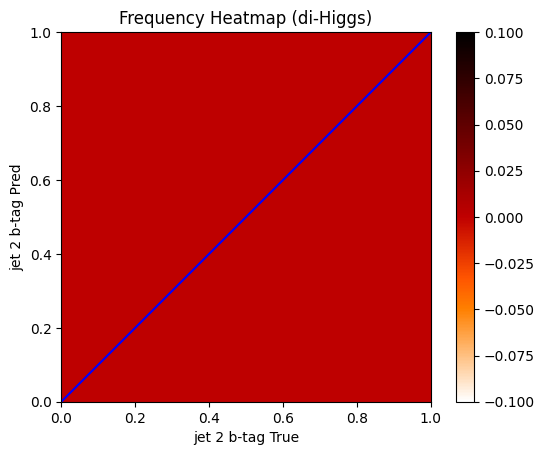

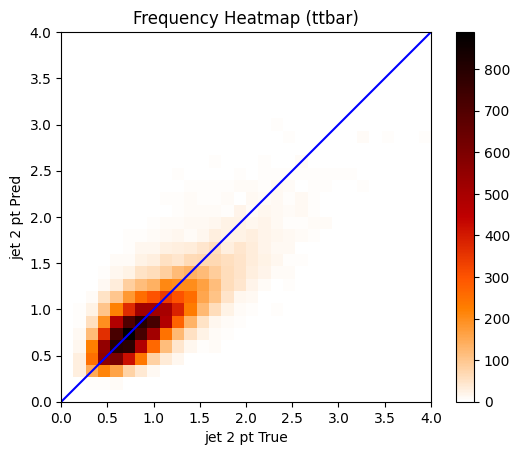

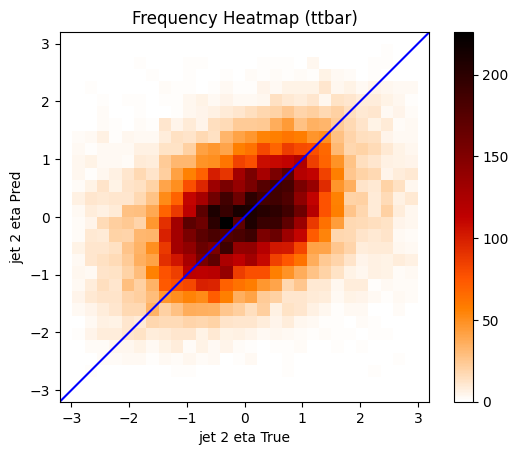

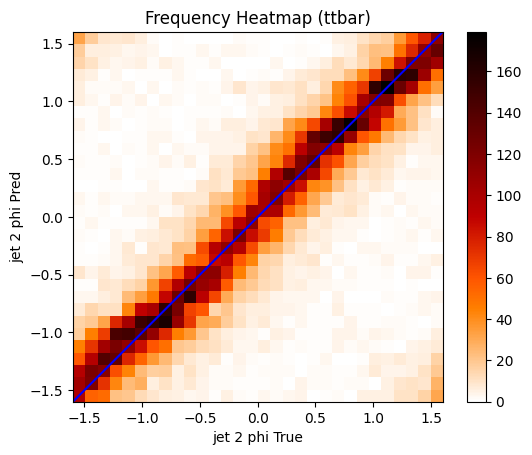

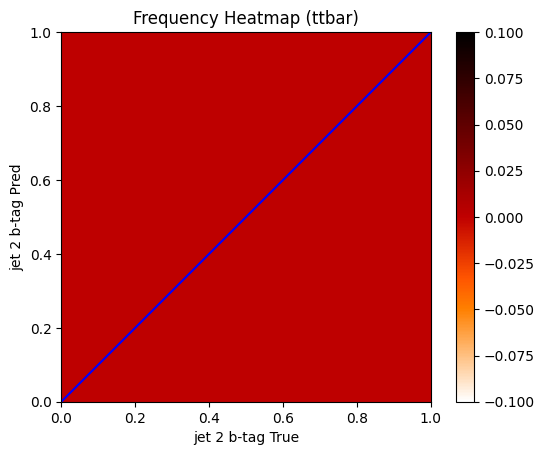

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


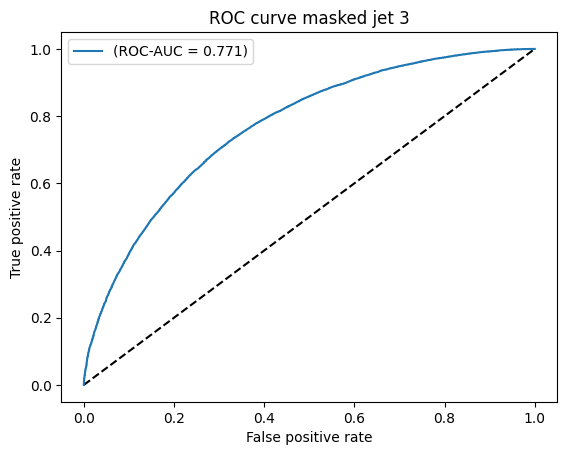

Classification Accuracy (masked  jet 3 ):  0.7029659406811863


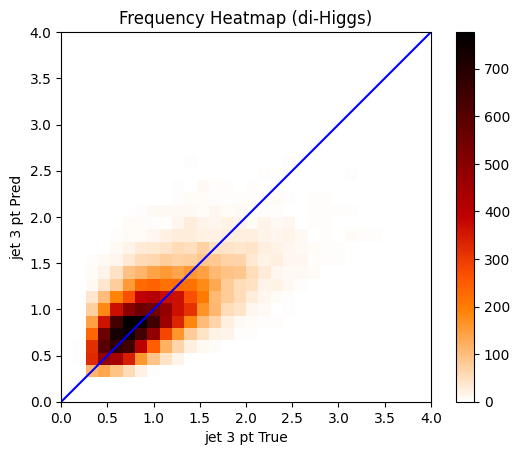

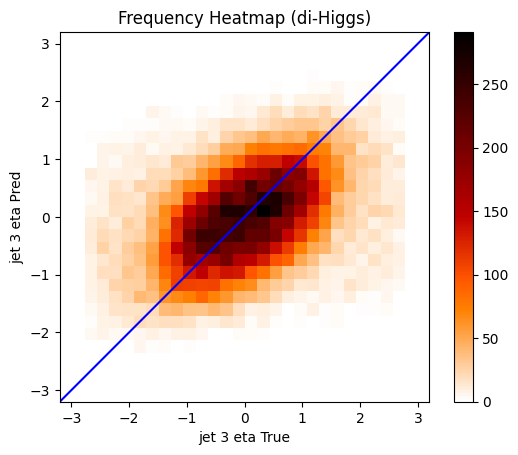

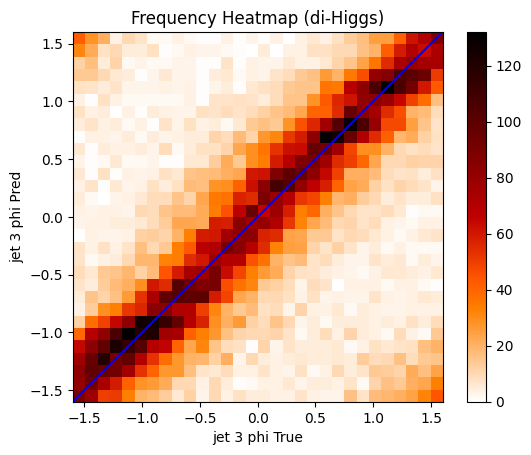

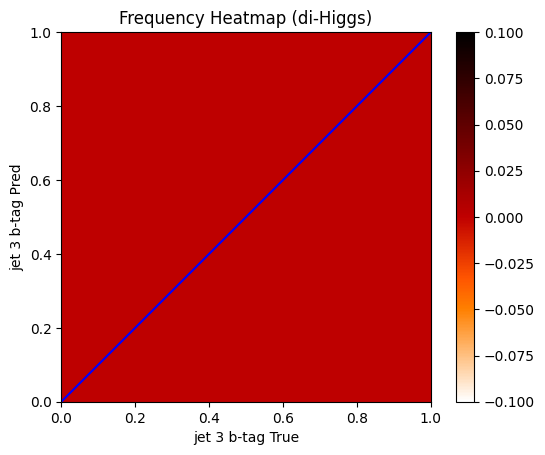

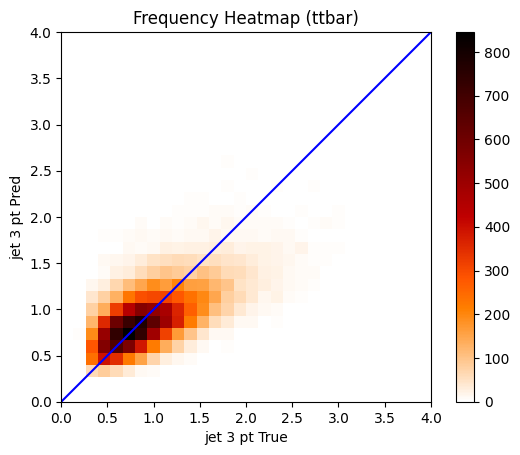

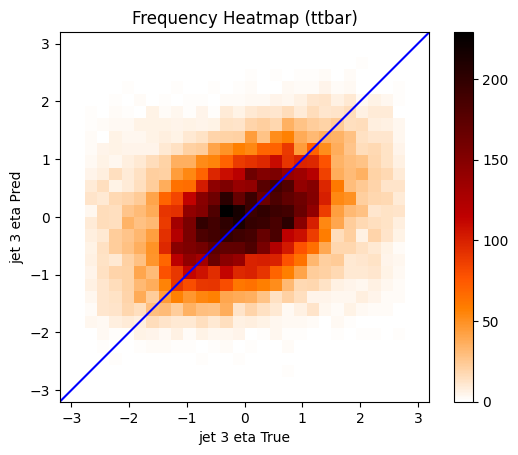

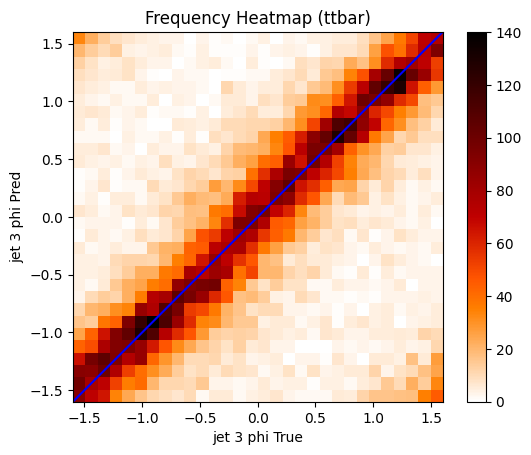

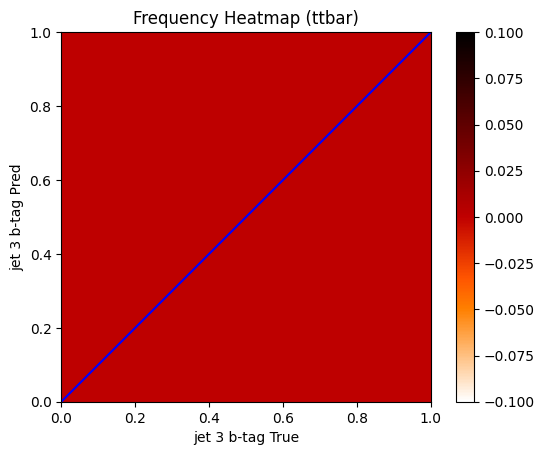

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


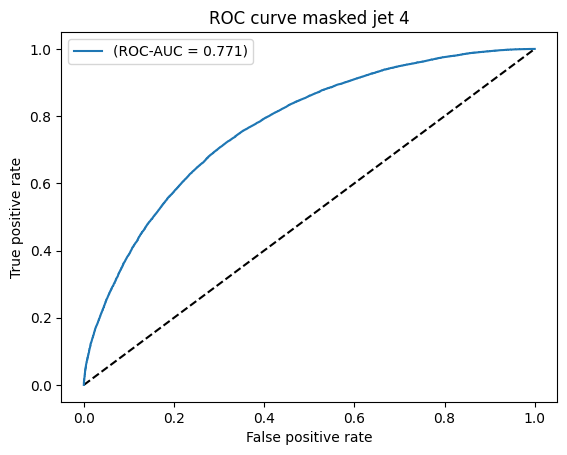

Classification Accuracy (masked  jet 4 ):  0.7039859202815943


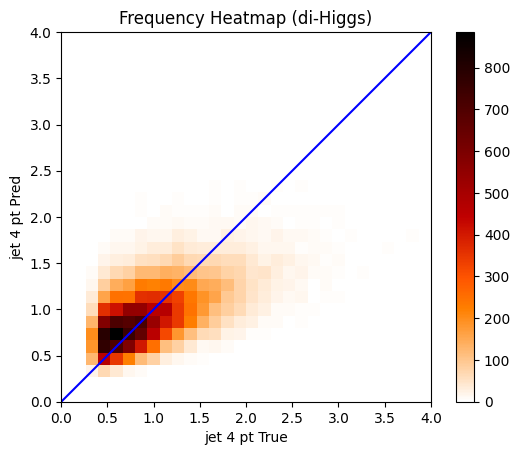

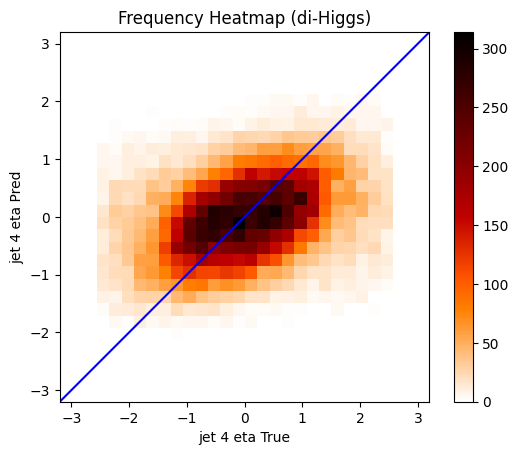

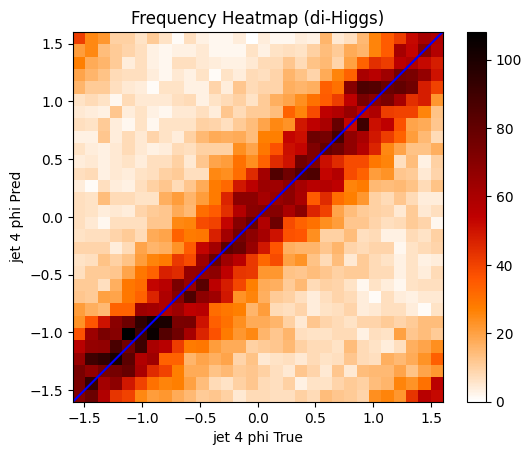

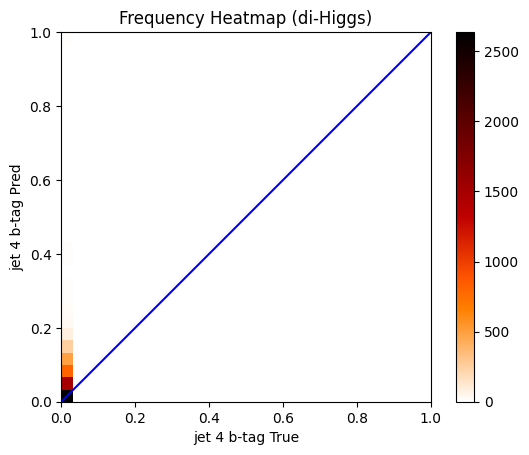

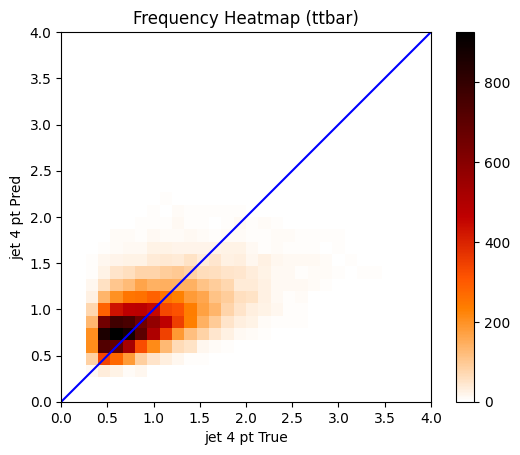

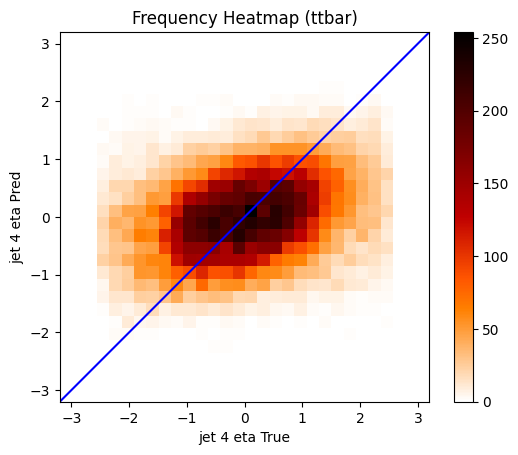

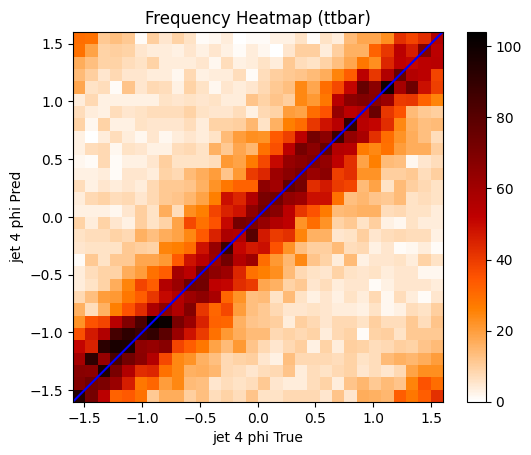

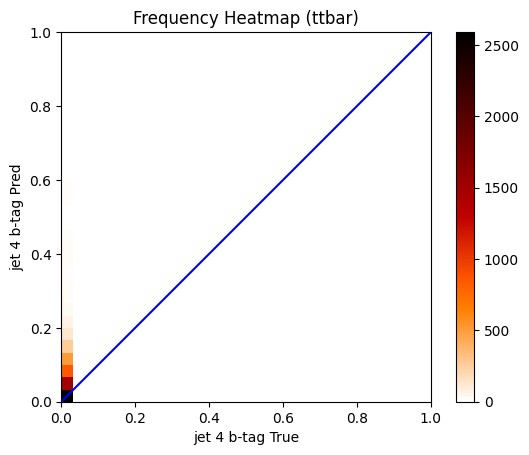

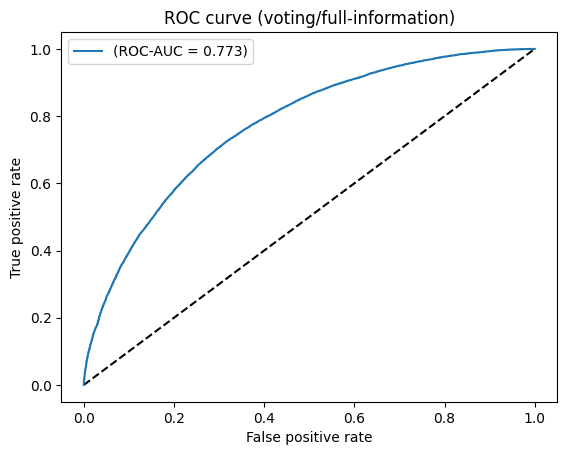

Classification Accuracy (voting/full-information):  0.7051058978820424


<Figure size 640x480 with 0 Axes>

In [ ]:
# Test the model and generate some plots
bin_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_full_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, bin_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'full', model_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


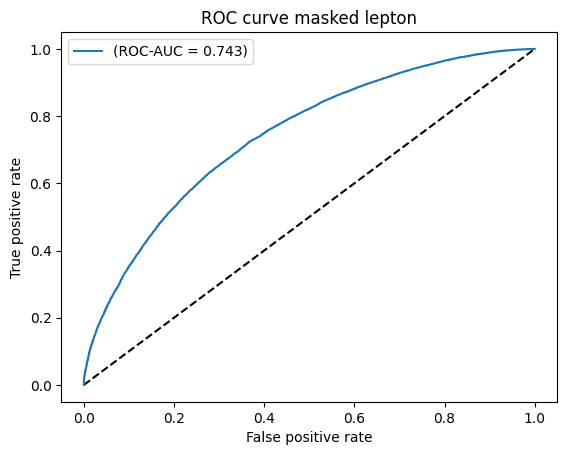

Classification Accuracy (masked  lepton ):  0.6792664146717066


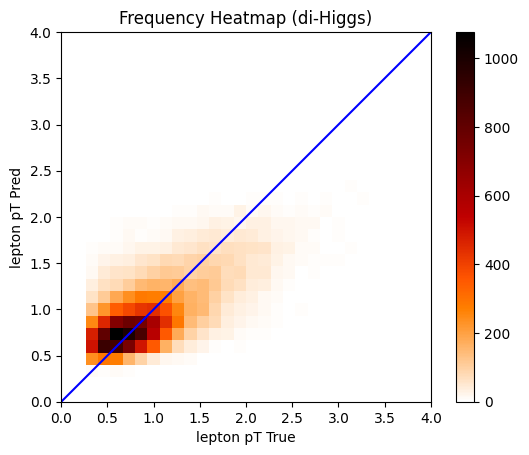

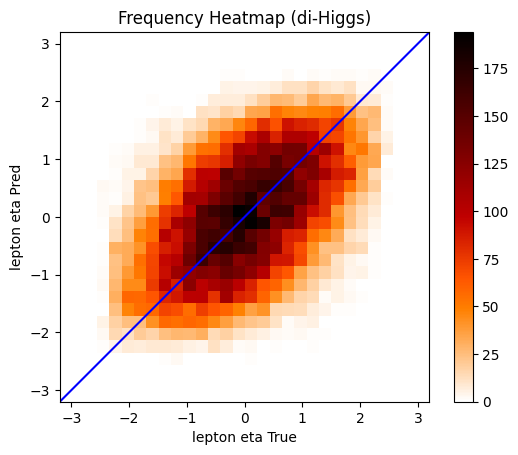

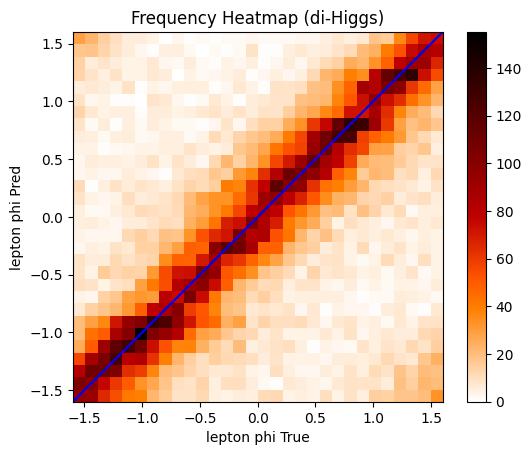

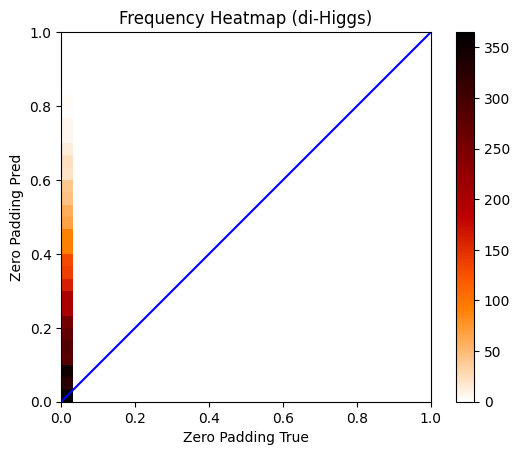

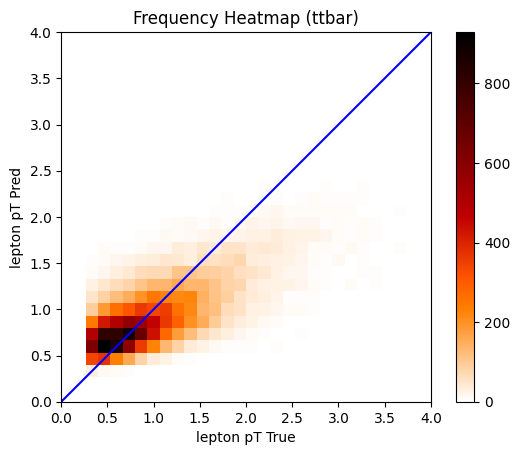

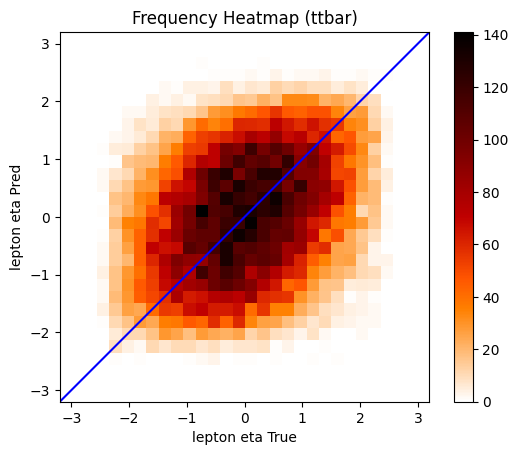

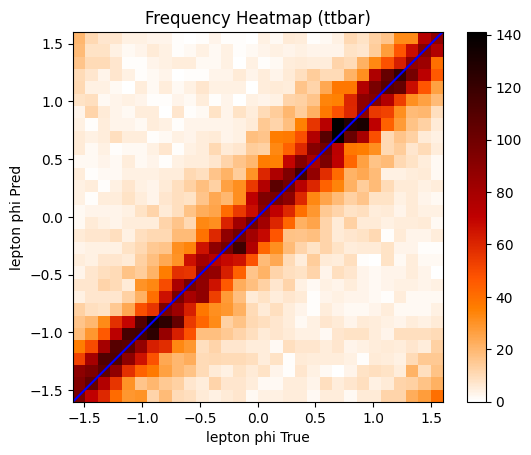

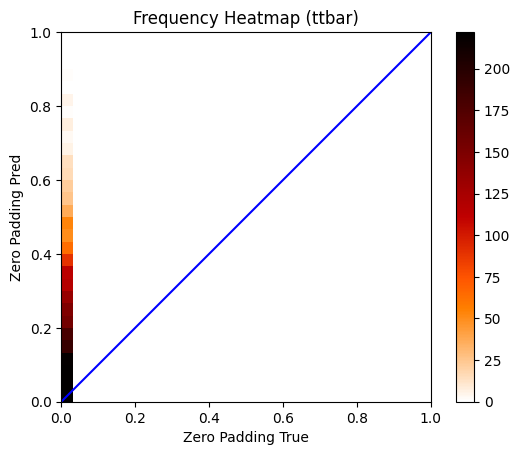

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


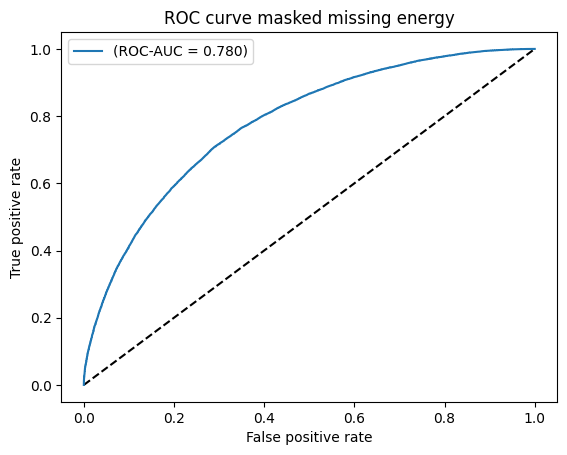

Classification Accuracy (masked  missing energy ):  0.7102457950840984


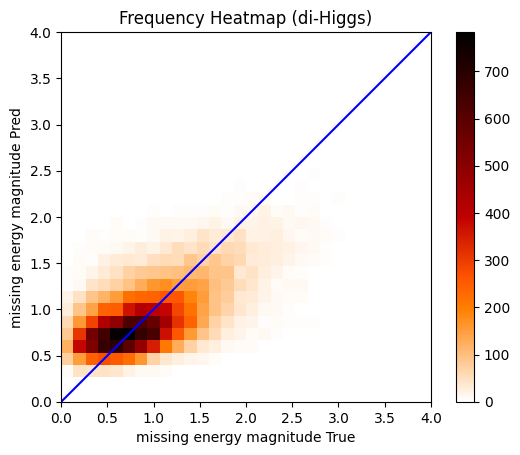

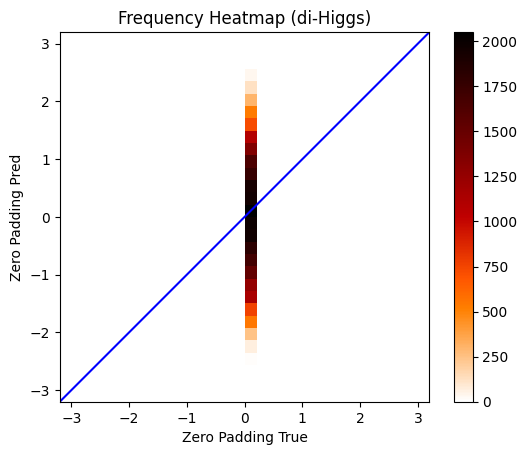

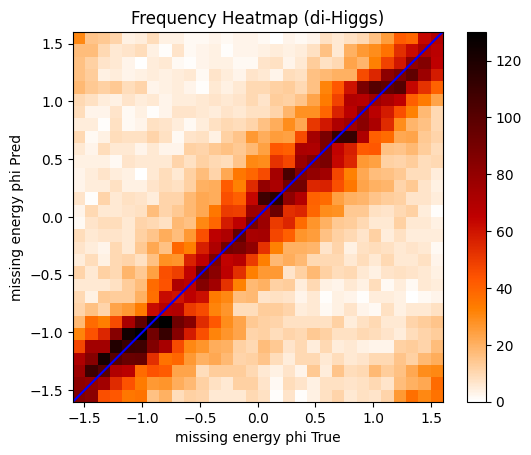

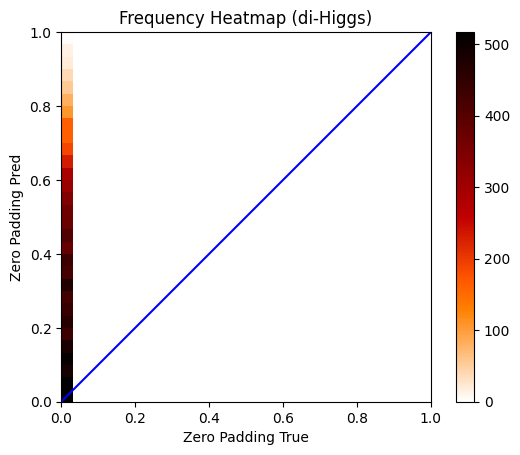

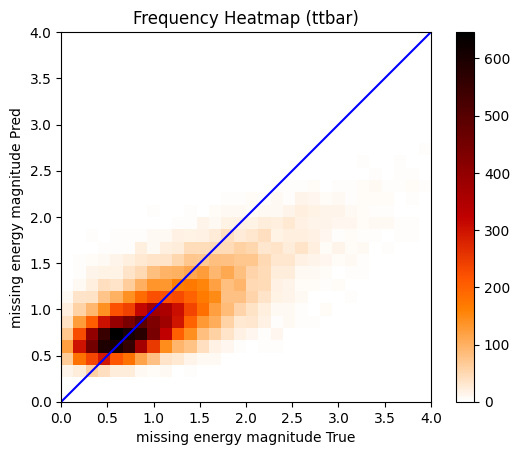

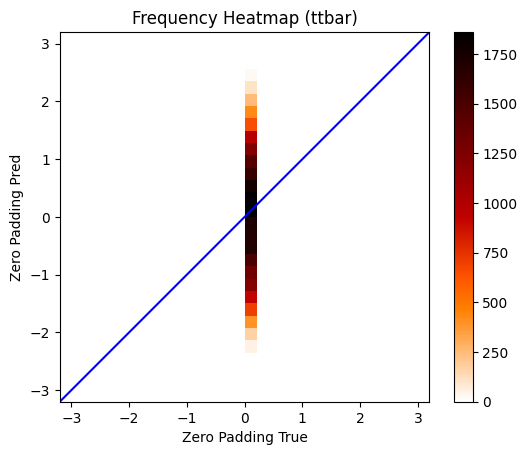

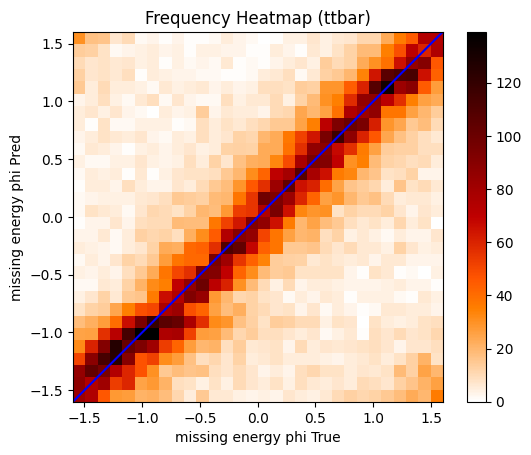

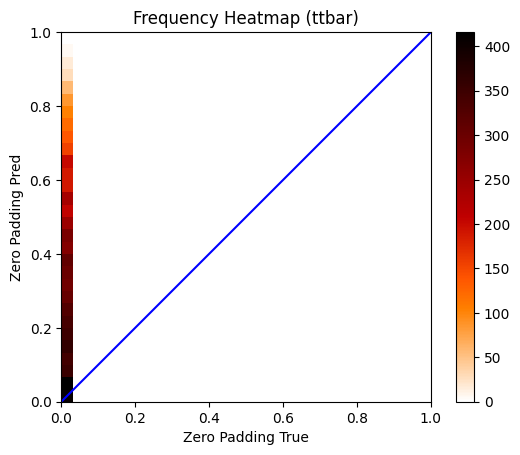

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


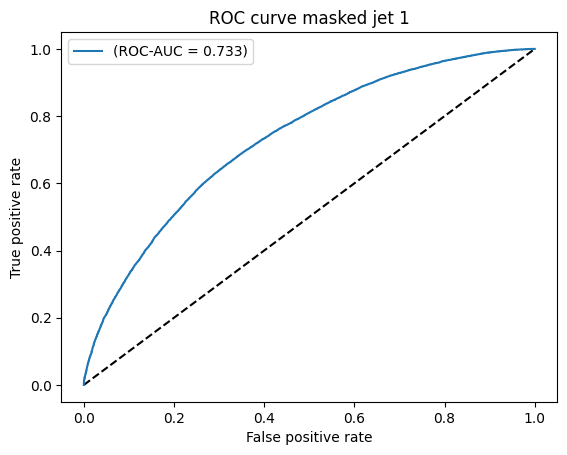

Classification Accuracy (masked  jet 1 ):  0.6706865862682746


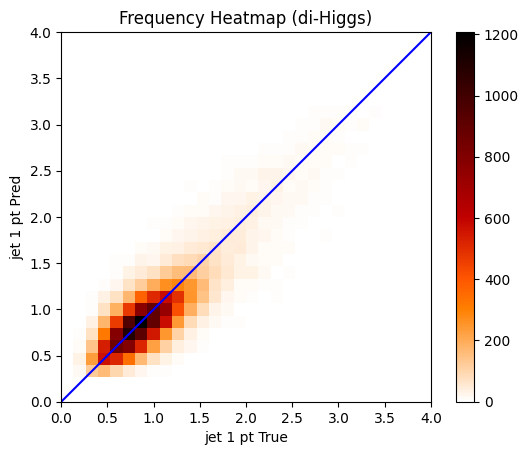

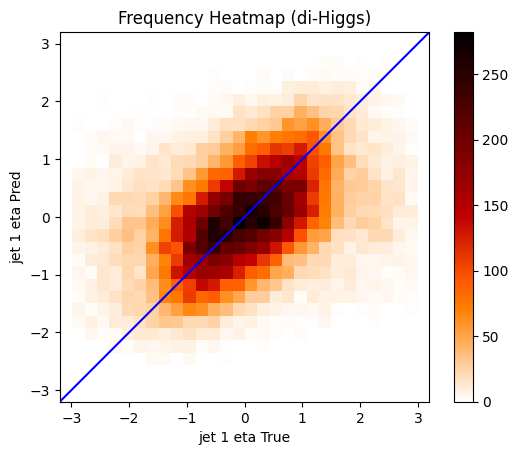

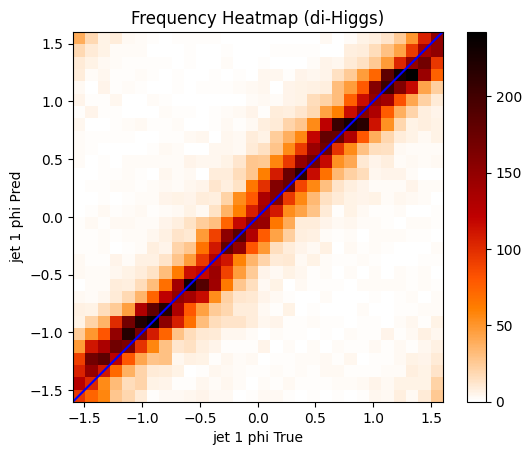

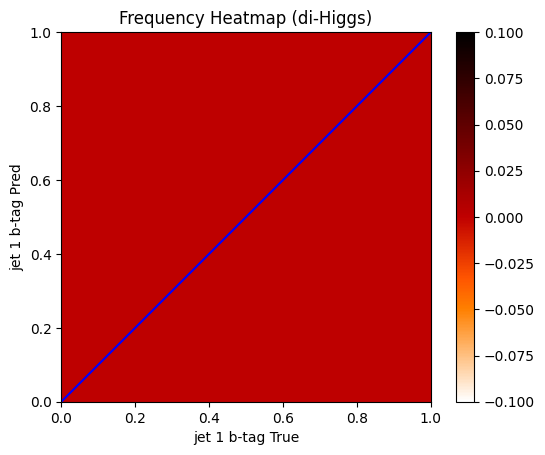

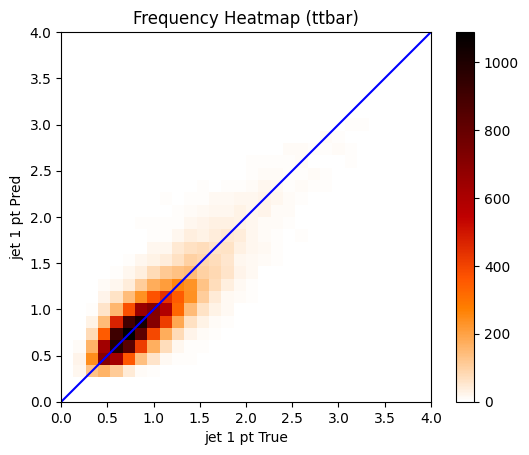

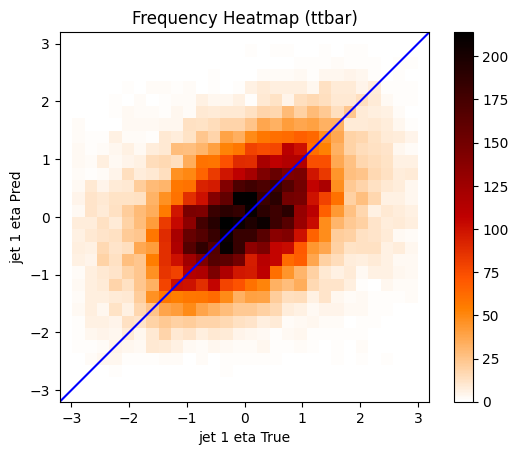

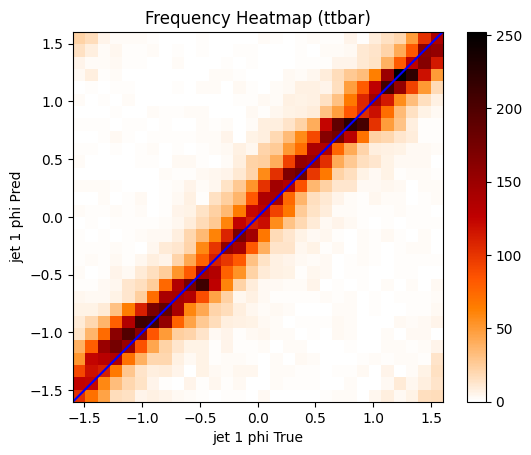

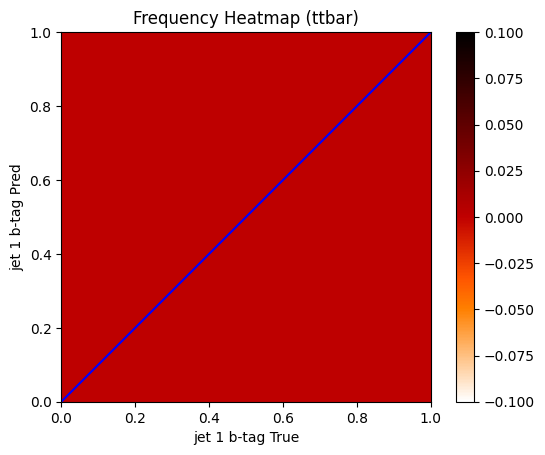

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


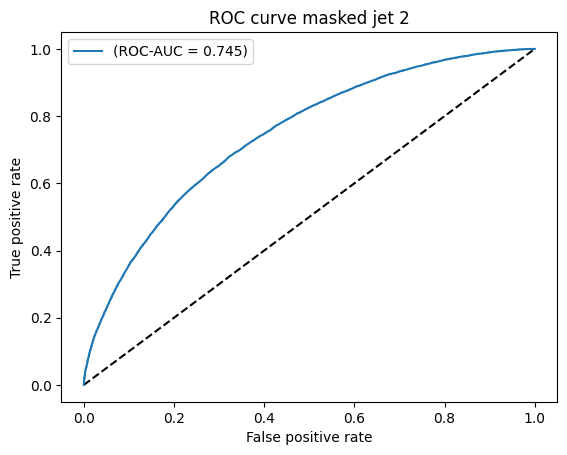

Classification Accuracy (masked  jet 2 ):  0.6786664266714666


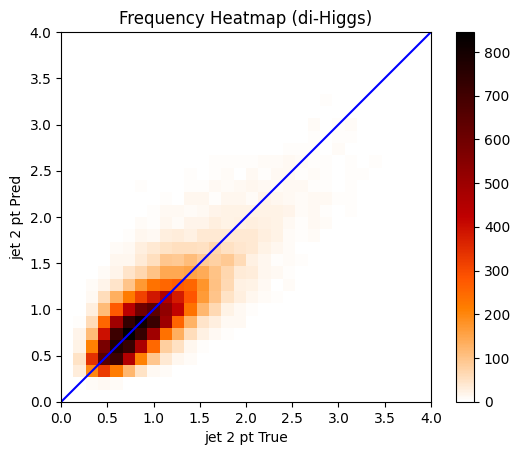

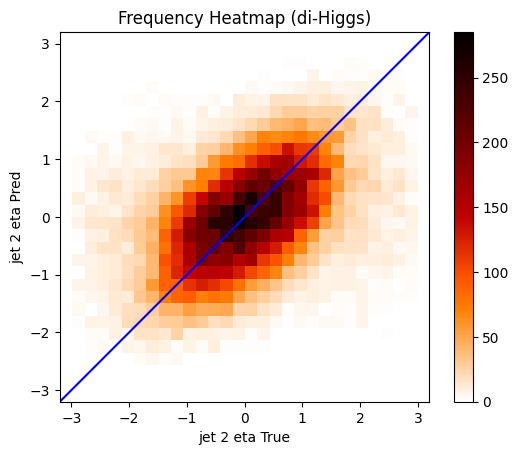

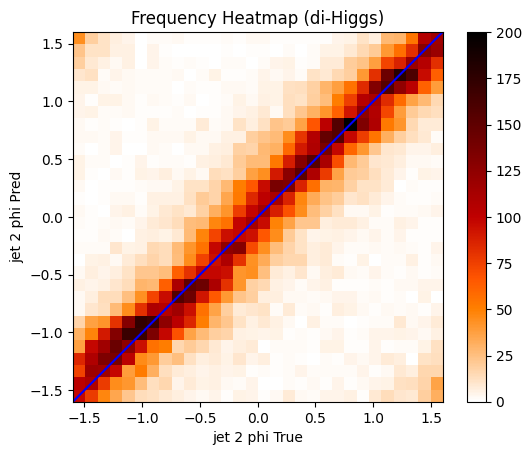

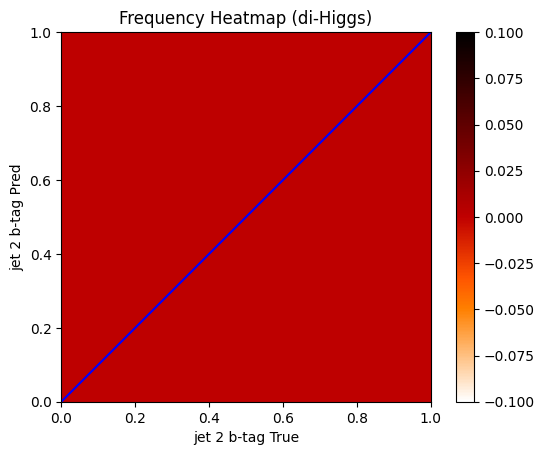

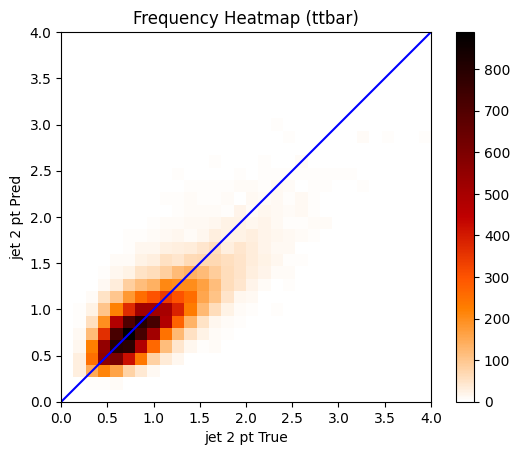

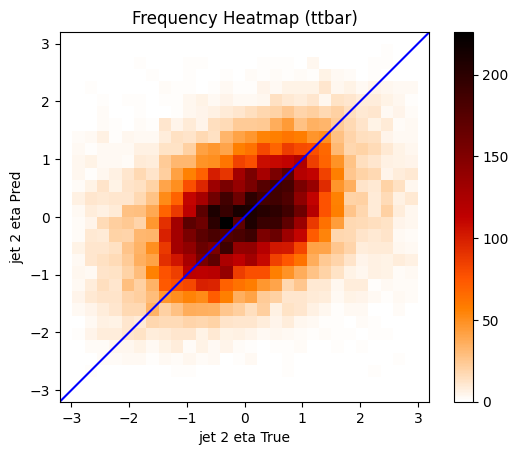

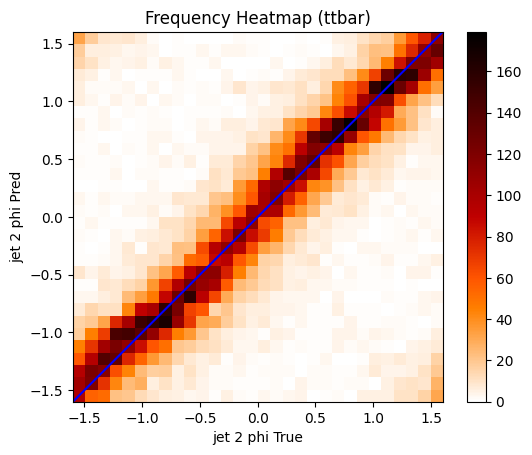

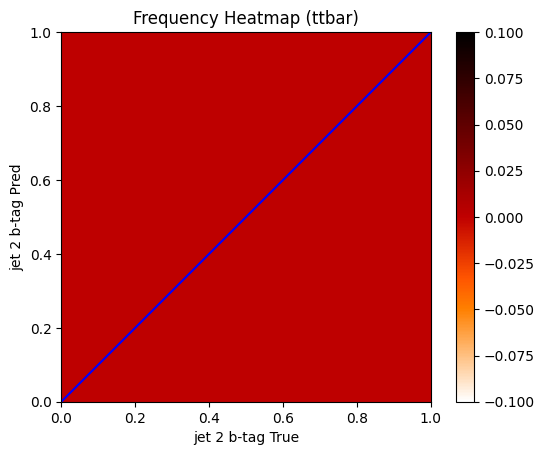

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


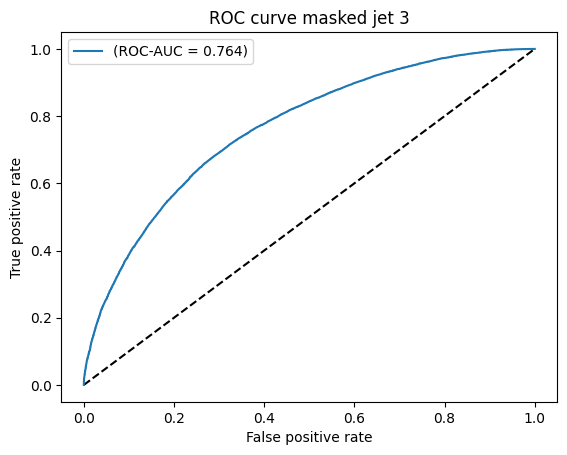

Classification Accuracy (masked  jet 3 ):  0.6967660646787064


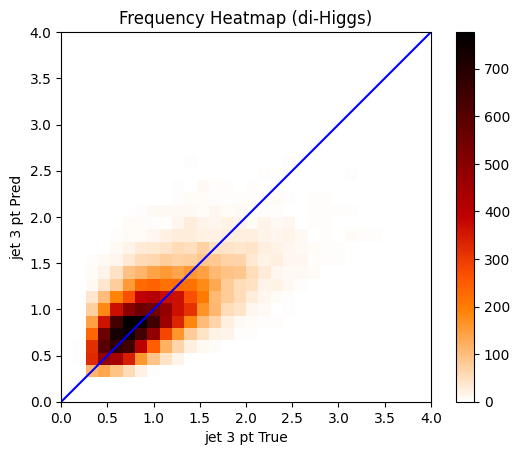

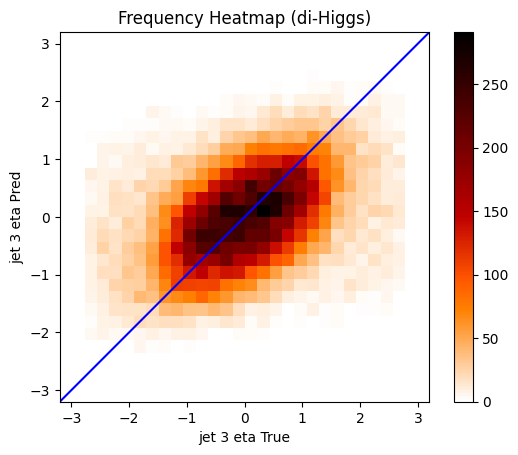

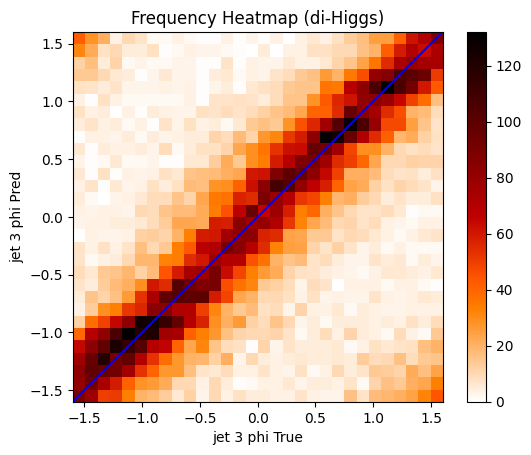

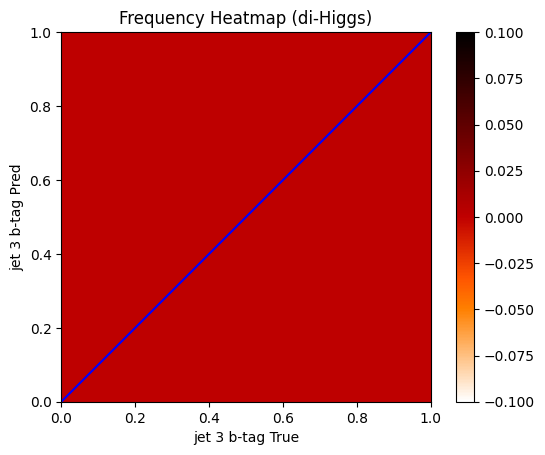

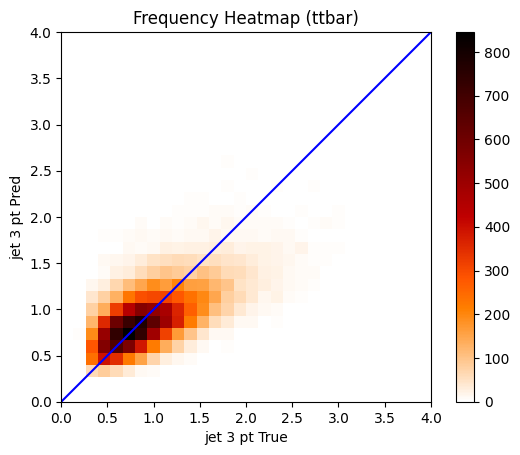

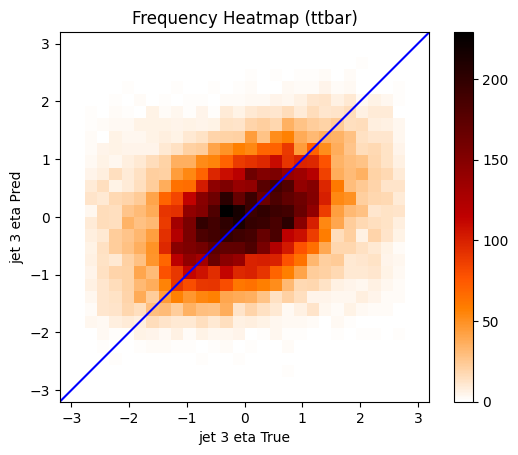

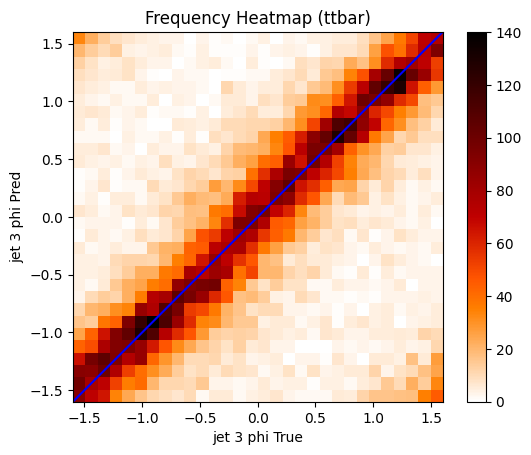

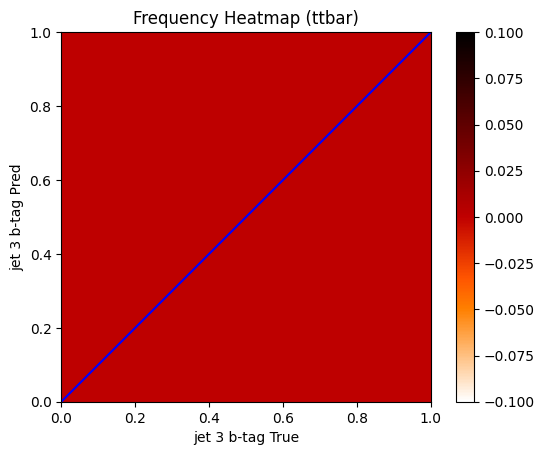

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


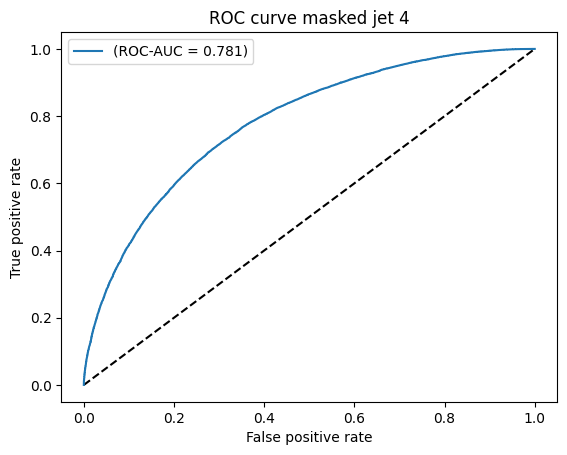

Classification Accuracy (masked  jet 4 ):  0.7098258034839303


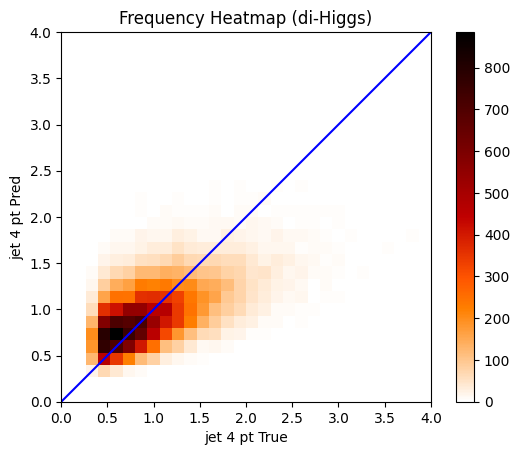

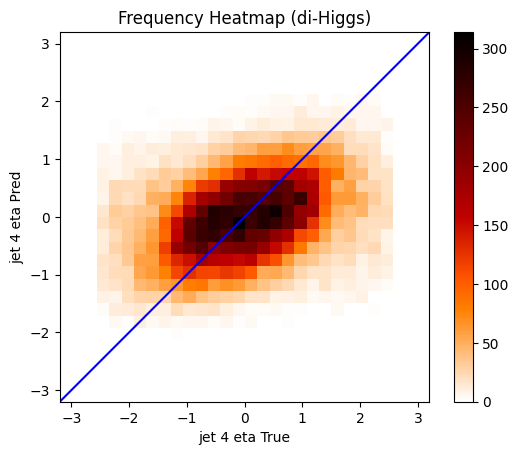

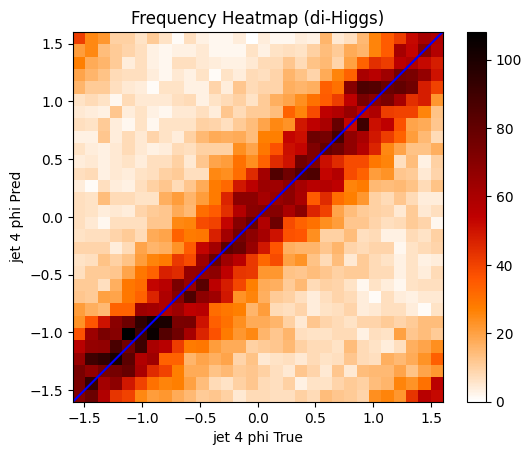

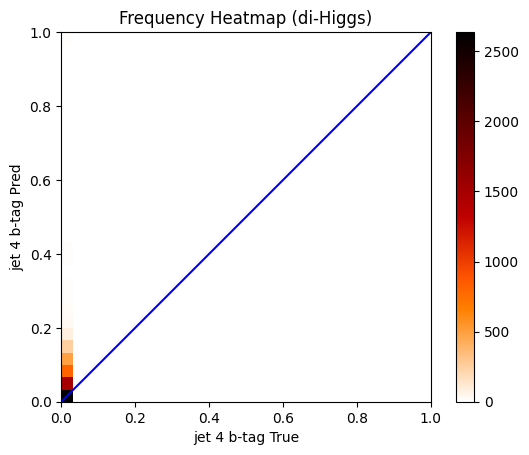

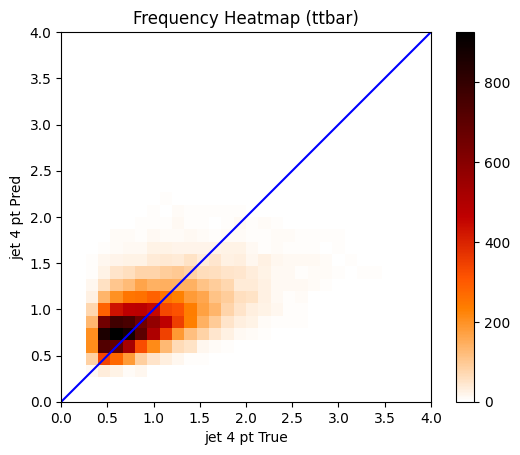

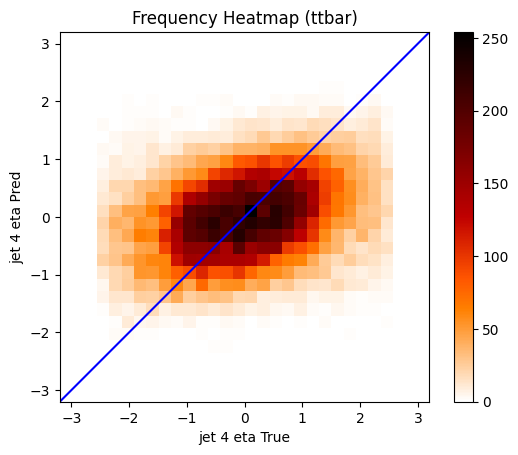

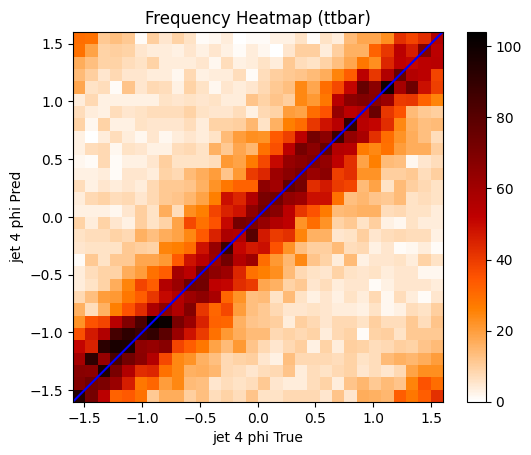

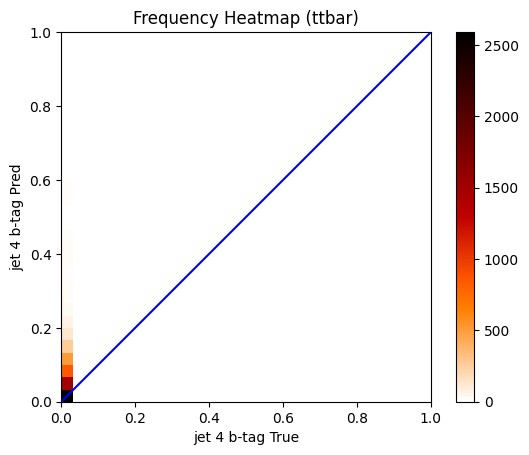

In [ ]:
bin_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_partial_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, bin_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'partial', model_name)